# Title: Lowest Housing Sale Price Among Similiar Boroughs

### Introduction/Business Problem

Singapore is a city-state with one of the most expensive housing market in the world.
About 80% of Singapore residents stay in public housing , managed by the Housing Development Board (HDB). In year 2018, the median sale price of HDB flat is S$408,000.
For someone looking to buy a new house in Singapore, this would mean careful research and planning is a must.

In this project, the objective to is help potential house owner make informed decision on the best Borough to purchase a HDB flat in, among other similar Boroughs.
Best borough in this case would be the lowest priced Borough among the other similiar Boroughs.

### Data

##### Definition:
1. Similiar Borough : Boroughs with simliar venues. As they have similiar amenities , this means the living conditions and lifestyles would be similar.
2. Lowest Housing Sale Price : Average price of all 2019 sale prices for each Borough


##### Data description:
1. Public housing flat resale price in 2019 from https://data.gov.sg/dataset/resale-flat-prices. 
2. This raw data to be clean and average sale price computed for each Borough
3. Use geopy library to get the latitude and longitude values of each Borough
4. Forsquare API to get the most common venues of each Borough



# CODE:

###### Download the dependencies

In [275]:
import urllib.request as urllib2
from bs4 import BeautifulSoup
import json
import re


import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


import pylab as pl #for elbow curve 


print('Libraries imported.')

Libraries imported.


###### Download Public housing flat resale price in 2019 from https://data.gov.sg/dataset/resale-flat-prices.

In [2]:
def download(url, user_agent='Mozilla/5.0', num_retries=2):
    print('Downloading:', url)
    headers = {'User-agent': user_agent}
    request = urllib2.Request(url, headers=headers)
    try:
        html = urllib2.urlopen(request).read()
    except urllib2.URLError as e:
        print('Download error:', e.reason)
        html = None
        if num_retries > 0:
            if hasattr(e, 'code') and 500 <= e.code < 600:
                # retry 5XX HTTP errors
                return download(url, user_agent, num_retries-1)
    return html


#url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&limit=5&q=2019'

#api of data.gov.sg:- limit records to 50k
url = 'https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&q=2019&limit=50000'


html = download(url)
type(html)

html_dict = json.loads(html.decode('utf-8'))

html_dict_records = html_dict['result']['records']
print('Number of records retrieved: ',len(html_dict_records))

#print(html_dict_records)

Downloading: https://data.gov.sg/api/action/datastore_search?resource_id=42ff9cfe-abe5-4b54-beda-c88f9bb438ee&q=2019&limit=50000
Number of records retrieved:  10396


###### Tranform the data into a pandas dataframe

In [3]:
type(html_dict_records)
html_dict_records[0]

{'_full_count': '10396',
 '_id': 47482,
 'block': '624A',
 'flat_model': 'Model A',
 'flat_type': '4 ROOM',
 'floor_area_sqm': '95',
 'lease_commence_date': '2014',
 'month': '2019-04',
 'rank': 0.0573088,
 'remaining_lease': '94 years',
 'resale_price': '470000',
 'storey_range': '13 TO 15',
 'street_name': 'PUNGGOL CTRL',
 'town': 'PUNGGOL'}

In [4]:
# define the dataframe columns
column_names = ['Borough', 'Street_Name', 'Resale_Price', 'Lease_Commence_Year', 'Floor_Area_Sqm', 'Flat_Type'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Street_Name,Resale_Price,Lease_Commence_Year,Floor_Area_Sqm,Flat_Type


In [5]:
#loop through the data and fill the dataframe one row at a time.
for data in html_dict_records:
    neighborhoods = neighborhoods.append({'Borough': data['town'],
                                          'Street_Name': data['street_name'],
                                          'Resale_Price': data['resale_price'],
                                          'Lease_Commence_Year': data['lease_commence_date'],
                                          'Floor_Area_Sqm': data['floor_area_sqm'],
                                          'Flat_Type': data['flat_type']
                                         }, ignore_index=True)
                                         
#remove duplicates
neighborhoods.drop_duplicates()

print('The dataframe has {} boroughs and {} records'.format(
        len(neighborhoods['Borough'].unique()), len(neighborhoods)
    )
)
neighborhoods.head()
#remove cells with a borough that is blank.
#neighborhoods_data = neighborhoods[neighborhoods['Resale_Price'] != ''].reset_index(drop=True)

The dataframe has 26 boroughs and 10396 records


,Borough,Street_Name,Resale_Price,Lease_Commence_Year,Floor_Area_Sqm,Flat_Type
0,PUNGGOL,PUNGGOL CTRL,470000,2014,95,4 ROOM
1,PUNGGOL,PUNGGOL WALK,590000,2015,113,5 ROOM
2,PUNGGOL,PUNGGOL WALK,555000,2015,113,5 ROOM
3,ANG MO KIO,ANG MO KIO AVE 1,270000,1981,68,3 ROOM
4,ANG MO KIO,ANG MO KIO AVE 1,295000,1976,73,3 ROOM


In [6]:
neighborhoods_pricedata = neighborhoods[['Borough','Resale_Price']].copy()

In [7]:
len(neighborhoods_pricedata)
neighborhoods_pricedata.head()

,Borough,Resale_Price
0,PUNGGOL,470000
1,PUNGGOL,590000
2,PUNGGOL,555000
3,ANG MO KIO,270000
4,ANG MO KIO,295000


In [8]:
#Change data type to Int
neighborhoods_pricedata['Resale_Price'] = neighborhoods_pricedata['Resale_Price'].astype("int")

In [9]:
#See data types
neighborhoods_pricedata.dtypes

Borough         object
Resale_Price     int64
dtype: object

In [10]:
neighborhoods_pricedata.head()

,Borough,Resale_Price
0,PUNGGOL,470000
1,PUNGGOL,590000
2,PUNGGOL,555000
3,ANG MO KIO,270000
4,ANG MO KIO,295000


In [11]:
#Average price for each Borough - include index
neighborhoods_avgprice_data = neighborhoods_pricedata.groupby(["Borough"]).mean().reset_index()

###### Use geopy library to get the latitude and longitude values of each Borough

In [12]:
neighborhoods_avgprice_data.head()

,Borough,Resale_Price
0,ANG MO KIO,382347.010776
1,BEDOK,399831.014572
2,BISHAN,617004.078818
3,BUKIT BATOK,380307.621053
4,BUKIT MERAH,561061.817967


In [14]:
#define geolocator function:

def get_location(address):
    
    geolocator = Nominatim(user_agent="tt_explorer")
    location = geolocator.geocode(address)
    latitude_sg = location.latitude
    longitude_sg = location.longitude
    #print(address, latitude_sg, longitude_sg)
    return latitude_sg, longitude_sg



In [178]:
nearby_names =[]
nearby_latitudes = []
nearby_longitudes = []
for i in neighborhoods_avgprice_data['Borough']:
    nearby_names.append(i)
    #add 'Singapore' to location name - make sure Singapore borough is retrieved
    sg_loc_name = i + ' Singapore'
    location_get = get_location(sg_loc_name)
    nearby_latitudes.append(location_get[0])
    nearby_longitudes.append(location_get[1])

In [179]:
print(len(nearby_names), len(nearby_latitudes), len(nearby_longitudes))

26 26 26


###### Define Foursquare Credentials and Version

In [180]:
# The code was removed by Watson Studio for sharing.

###### Create a function to repeat the same process to all the neighborhoods in Singapore

In [181]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

###### Write the code to run the above function on each neighborhood and create a new dataframe called sg_venues.

In [185]:
LIMIT = 100 #limit of number of venues returned by Foursquare API

import requests # library to handle requests

sg_venues = getNearbyVenues(nearby_names, nearby_latitudes, nearby_longitudes)

ANG MO KIO
BEDOK
BISHAN
BUKIT BATOK
BUKIT MERAH
BUKIT PANJANG
BUKIT TIMAH
CENTRAL AREA
CHOA CHU KANG
CLEMENTI
GEYLANG
HOUGANG
JURONG EAST
JURONG WEST
KALLANG/WHAMPOA
MARINE PARADE
PASIR RIS
PUNGGOL
QUEENSTOWN
SEMBAWANG
SENGKANG
SERANGOON
TAMPINES
TOA PAYOH
WOODLANDS
YISHUN


In [186]:
#Check the size of the resulting dataframe
print(sg_venues.shape)
sg_venues.head()

(981, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ANG MO KIO,1.369842,103.846609,Old Chang Kee,1.369094,103.848389,Snack Place
1,ANG MO KIO,1.369842,103.846609,Subway,1.369136,103.847612,Sandwich Place
2,ANG MO KIO,1.369842,103.846609,Bun Master,1.369242,103.849031,Bakery
3,ANG MO KIO,1.369842,103.846609,MOS Burger,1.369170,103.847831,Burger Joint
4,ANG MO KIO,1.369842,103.846609,PLAYe,1.369109,103.848225,Hobby Shop


In [187]:
#Check how many venues were returned for each neighborhood
sg_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
ANG MO KIO,47,47,47,47,47,47
BEDOK,58,58,58,58,58,58
BISHAN,42,42,42,42,42,42
BUKIT BATOK,27,27,27,27,27,27
BUKIT MERAH,39,39,39,39,39,39
BUKIT PANJANG,8,8,8,8,8,8
BUKIT TIMAH,12,12,12,12,12,12
CENTRAL AREA,84,84,84,84,84,84
CHOA CHU KANG,12,12,12,12,12,12


In [188]:
#Find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 157 uniques categories.


###### Analyze Each Neighborhood

In [189]:
# one hot encoding
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sg_onehot['Neighborhood'] = sg_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Beer Garden,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cantonese Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,Food Stand,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Health & Beauty Service,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Music Store,Music Venue,Neighborhood,Nightclub,Noodle House,Outdoor Sculpture,Paella Restaurant,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Ramen Restaurant,Recreation Center,Resort,Rest Area,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Spa,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Water Park,Waterfront,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ANG MO KIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [190]:
#Examine the new dataframe size.
sg_onehot.shape

(981, 157)

###### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [212]:
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Basketball Court,Beer Garden,Betting Shop,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Café,Cantonese Restaurant,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Event Space,Fast Food Restaurant,Flower Shop,Food & Drink Shop,Food Court,Food Stand,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Gastropub,General Entertainment,German Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Halal Restaurant,Health & Beauty Service,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hostel,Hot Dog Joint,Hotel,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Multiplex,Music Store,Music Venue,Nightclub,Noodle House,Outdoor Sculpture,Paella Restaurant,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pool Hall,Portuguese Restaurant,Post Office,Ramen Restaurant,Recreation Center,Resort,Rest Area,Restaurant,Salad Place,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soup Place,Spa,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Water Park,Waterfront,Wings Joint
0,ANG MO KIO,0.000000,0.0,0.000000,0.0,0.0,0.0,0.021277,0.0,0.000000,0.021277,0.021277,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.063830,0.0,0.021277,0.0,0.000000,0.000000,0.000000,0.0,0.021277,0.0,0.0,0.021277,0.000000,0.0,0.0,0.106383,0.0,0.0,0.0,0.021277,0.000000,0.000000,0.000000,0.042553,0.0,0.0,0.000000,0.021277,0.0,0.063830,0.000000,0.0,0.063830,0.0,0.000000,0.000000,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.021277,0.021277,0.000000,0.021277,0.0,0.0,0.0,0.021277,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.042553,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.021277,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.021277,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.000000,0.000000,0.021277,0.0,0.0,0.021277,0.0,0.0,0.0,0.000000,0.0,0.042553,0.0,0.0,0.021277,0.0,0.021277,0.000000,0.0,0.000000,0.021277,0.000000,0.000000,0.000000,0.00000,0.0,0.042553,0.042553,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.021277,0.0,0.0,0.0,0.000000
1,BEDOK,0.000000,0.0,0.017241,0.0,0.0,0.0,0.051724,0.0,0.000000,0.017241,0.000000,0.0,0.0,0.0,0.0,0.0,0.017241,0.000000,0.000000,0.017241,0.0,0.017241,0.0,0.017241,0.0,0.017241,0.000000,0.000000,0.0,0.034483,0.0,0.0,0.034483,0.017241,0.0,0.0,0.068966,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.017241,0.017241,0.0,0.0,0.017241,0.000000,0.0,0.034483,0.000000,0.0,0.051724,0.0,0.017241,0.017241,0.017241,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.017241,0.000000,0.0,0.0,0.017241,0.017241,0.017241,0.017241,0.017241,0.0,0.051724,0.0,0.0,0.017241,0.00000,0.0,0.0,0.0,0.017241,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0,0.00000,0.00000,0.0,0.0,0.017241,0.017241,0.000000,0.

In [192]:
#Confirm the new size
sg_grouped.shape

(26, 157)

# Explore the neighborhoods in Singapore

In [193]:
num_top_venues = 5

for hood in sg_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = sg_grouped[sg_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ANG MO KIO----
                  venue  freq
0           Coffee Shop  0.11
1            Food Court  0.06
2  Fast Food Restaurant  0.06
3       Bubble Tea Shop  0.06
4           Supermarket  0.04


----BEDOK----
                 venue  freq
0          Coffee Shop  0.07
1  Japanese Restaurant  0.05
2           Food Court  0.05
3       Sandwich Place  0.05
4     Asian Restaurant  0.05


----BISHAN----
                venue  freq
0         Coffee Shop  0.10
1     Bubble Tea Shop  0.07
2          Food Court  0.07
3                Café  0.05
4  Chinese Restaurant  0.05


----BUKIT BATOK----
                venue  freq
0         Coffee Shop  0.19
1  Chinese Restaurant  0.11
2          Food Court  0.07
3  Frozen Yogurt Shop  0.04
4         Bus Station  0.04


----BUKIT MERAH----
                venue  freq
0    Asian Restaurant  0.13
1                Café  0.10
2  Chinese Restaurant  0.08
3         Coffee Shop  0.05
4           Bookstore  0.05


----BUKIT PANJANG----
                 venue

###### Put into a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [194]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [195]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ANG MO KIO,Coffee Shop,Food Court,Bubble Tea Shop,Fast Food Restaurant,Sushi Restaurant,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant,Malay Restaurant
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Japanese Restaurant,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Supermarket,Sushi Restaurant,Café
2,BISHAN,Coffee Shop,Bubble Tea Shop,Food Court,Cosmetics Shop,Café,Japanese Restaurant,Chinese Restaurant,Ice Cream Shop,Supermarket,Electronics Store
3,BUKIT BATOK,Coffee Shop,Chinese Restaurant,Food Court,Shopping Mall,Frozen Yogurt Shop,Department Store,Multiplex,Fast Food Restaurant,Café,Mobile Phone Shop
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Noodle House,Bookstore,Coffee Shop,Yoga Studio,Bus Station,Boutique,Breakfast Spot


# Cluster the neighborhoods in Singapore

In [276]:
#get dataset ready for clustering
sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

Use Elbow Curve to determine nummber of clusters

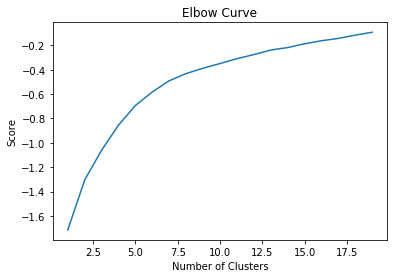

In [277]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

kmeans

score = [kmeans[i].fit(sg_grouped_clustering).score(sg_grouped_clustering) for i in range(len(kmeans))]

score

pl.plot(Nc,score)

pl.xlabel('Number of Clusters')

pl.ylabel('Score')

pl.title('Elbow Curve')

pl.show()

Run k-means to cluster the neighborhood into 8 clusters - from above Elbow Curve

In [280]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 7, 1, 5, 3, 1, 6, 1], dtype=int32)

In [281]:
labels = kmeans.labels_

In [282]:
#We assign the labels to each row in dataframe.
neighborhoods_venues_sorted['Cluster_Number'] = labels
neighborhoods_venues_sorted.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number
0,ANG MO KIO,Coffee Shop,Food Court,Bubble Tea Shop,Fast Food Restaurant,Sushi Restaurant,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant,Malay Restaurant,1
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Japanese Restaurant,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Supermarket,Sushi Restaurant,Café,1
2,BISHAN,Coffee Shop,Bubble Tea Shop,Food Court,Cosmetics Shop,Café,Japanese Restaurant,Chinese Restaurant,Ice Cream Shop,Supermarket,Electronics Store,1
3,BUKIT BATOK,Coffee Shop,Chinese Restaurant,Food Court,Shopping Mall,Frozen Yogurt Shop,Department Store,Multiplex,Fast Food Restaurant,Café,Mobile Phone Shop,7
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Noodle House,Bookstore,Coffee Shop,Yoga Studio,Bus Station,Boutique,Breakfast Spot,1


In [285]:
#Rename column Borough to Neighorhood , before joining
neighborhoods_price = neighborhoods_avgprice_data.rename(columns={"Borough":"Neighborhood"})

In [286]:
neighborhoods_price.head()

,Neighborhood,Resale_Price
0,ANG MO KIO,382347.010776
1,BEDOK,399831.014572
2,BISHAN,617004.078818
3,BUKIT BATOK,380307.621053
4,BUKIT MERAH,561061.817967


In [287]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number
0,ANG MO KIO,Coffee Shop,Food Court,Bubble Tea Shop,Fast Food Restaurant,Sushi Restaurant,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant,Malay Restaurant,1
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Japanese Restaurant,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Supermarket,Sushi Restaurant,Café,1
2,BISHAN,Coffee Shop,Bubble Tea Shop,Food Court,Cosmetics Shop,Café,Japanese Restaurant,Chinese Restaurant,Ice Cream Shop,Supermarket,Electronics Store,1
3,BUKIT BATOK,Coffee Shop,Chinese Restaurant,Food Court,Shopping Mall,Frozen Yogurt Shop,Department Store,Multiplex,Fast Food Restaurant,Café,Mobile Phone Shop,7
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Noodle House,Bookstore,Coffee Shop,Yoga Studio,Bus Station,Boutique,Breakfast Spot,1


In [288]:
#Merge both dataframe together to get both Cluster number and Average Resale Price
combined_data = neighborhoods_venues_sorted.merge(neighborhoods_price, on='Neighborhood', how='left')

In [289]:
combined_data.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number,Resale_Price
0,ANG MO KIO,Coffee Shop,Food Court,Bubble Tea Shop,Fast Food Restaurant,Sushi Restaurant,Supermarket,Dessert Shop,Sandwich Place,Japanese Restaurant,Malay Restaurant,1,382347.010776
1,BEDOK,Coffee Shop,Food Court,Asian Restaurant,Japanese Restaurant,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Supermarket,Sushi Restaurant,Café,1,399831.014572
2,BISHAN,Coffee Shop,Bubble Tea Shop,Food Court,Cosmetics Shop,Café,Japanese Restaurant,Chinese Restaurant,Ice Cream Shop,Supermarket,Electronics Store,1,617004.078818
3,BUKIT BATOK,Coffee Shop,Chinese Restaurant,Food Court,Shopping Mall,Frozen Yogurt Shop,Department Store,Multiplex,Fast Food Restaurant,Café,Mobile Phone Shop,7,380307.621053
4,BUKIT MERAH,Asian Restaurant,Café,Chinese Restaurant,Noodle House,Bookstore,Coffee Shop,Yoga Studio,Bus Station,Boutique,Breakfast Spot,1,561061.817967


In [290]:
combined_data_sorted = combined_data.sort_values(['Cluster_Number', 'Resale_Price'], ascending=True)

# Visualize the resulting clusters

In [291]:
#Get Singapore location
sin_latitude, sin_longitude=get_location('Singapore')


In [292]:
#Create dataframe with neighbour latitude and longitude
sin_neighborhood_location = sg_venues[['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude']].copy().drop_duplicates()

In [293]:
sin_neighborhood_location.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,ANG MO KIO,1.369842,103.846609
47,BEDOK,1.323976,103.930216
105,BISHAN,1.351452,103.848250
147,BUKIT BATOK,1.349057,103.749591
174,BUKIT MERAH,1.280628,103.830591


In [294]:
#Merge both dataframe together to get both Cluster number and Average Resale Price
combined_data_location = combined_data_sorted.merge(sin_neighborhood_location, on='Neighborhood', how='left')

In [295]:
combined_data_location.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster_Number,Resale_Price,Neighborhood Latitude,Neighborhood Longitude
0,GEYLANG,Chinese Restaurant,Noodle House,Food Court,Vegetarian / Vegan Restaurant,Asian Restaurant,Dim Sum Restaurant,Grocery Store,Steakhouse,Coffee Shop,Dessert Shop,0,429117.338645,1.318186,103.887056
1,QUEENSTOWN,Chinese Restaurant,Food Court,Noodle House,Pool,Spa,Stadium,Café,Seafood Restaurant,Dessert Shop,Italian Restaurant,0,560373.724265,1.294623,103.806045
2,SEMBAWANG,Coffee Shop,Fast Food Restaurant,Asian Restaurant,Supermarket,Electronics Store,Chinese Restaurant,Café,Bus Stop,Bus Station,Shopping Mall,1,365279.450980,1.448065,103.820760
3,WOODLANDS,Japanese Restaurant,Chinese Restaurant,Pizza Place,Café,Clothing Store,Indian Restaurant,Coffee Shop,Electronics Store,Fast Food Restaurant,Food Court,1,367538.507446,1.436897,103.786216
4,YISHUN,Coffee Shop,Food Court,Chinese Restaurant,Hainan Restaurant,Fast Food Restaurant,Noodle House,Supermarket,Bookstore,Shopping Mall,Fried Chicken Joint,1,367901.483651,1.428136,103.833694


Create and display Singapore map with clusters

In [309]:
# create map
map_clusters = folium.Map(location=[sin_latitude, sin_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(combined_data_location['Neighborhood Latitude'], combined_data_location['Neighborhood Longitude'], combined_data_location['Neighborhood'], combined_data_location['Cluster_Number']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Display Lowest Housing Sale Price Among Similiar Boroughs

###### Lowest Housing Sale Price Borough in Cluster 1

In [297]:
#Cluster 1
cluster1 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 0, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster1.iloc[0]

Neighborhood                                    GEYLANG
1st Most Common Venue                Chinese Restaurant
2nd Most Common Venue                      Noodle House
3rd Most Common Venue                        Food Court
4th Most Common Venue     Vegetarian / Vegan Restaurant
5th Most Common Venue                  Asian Restaurant
6th Most Common Venue                Dim Sum Restaurant
7th Most Common Venue                     Grocery Store
8th Most Common Venue                        Steakhouse
9th Most Common Venue                       Coffee Shop
10th Most Common Venue                     Dessert Shop
Cluster_Number                                        0
Resale_Price                                     429117
Neighborhood Latitude                           1.31819
Neighborhood Longitude                          103.887
Name: 0, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 2

In [298]:
#Cluster 2
cluster2 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 1, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster2.iloc[0]

Neighborhood                         SEMBAWANG
1st Most Common Venue              Coffee Shop
2nd Most Common Venue     Fast Food Restaurant
3rd Most Common Venue         Asian Restaurant
4th Most Common Venue              Supermarket
5th Most Common Venue        Electronics Store
6th Most Common Venue       Chinese Restaurant
7th Most Common Venue                     Café
8th Most Common Venue                 Bus Stop
9th Most Common Venue              Bus Station
10th Most Common Venue           Shopping Mall
Cluster_Number                               1
Resale_Price                            365279
Neighborhood Latitude                  1.44806
Neighborhood Longitude                 103.821
Name: 2, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 3

In [299]:
#Cluster 3
cluster3 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 2, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster3.iloc[0]

Neighborhood                         PUNGGOL
1st Most Common Venue            Bus Station
2nd Most Common Venue      Convenience Store
3rd Most Common Venue               Bus Stop
4th Most Common Venue            High School
5th Most Common Venue     Chinese Restaurant
6th Most Common Venue      French Restaurant
7th Most Common Venue             Food Stand
8th Most Common Venue             Food Court
9th Most Common Venue      Food & Drink Shop
10th Most Common Venue           Flower Shop
Cluster_Number                             2
Resale_Price                          463184
Neighborhood Latitude                1.39803
Neighborhood Longitude               103.907
Name: 19, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 4

In [304]:
#Cluster 4
cluster4 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 3, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster4.iloc[0]

Neighborhood                       BUKIT TIMAH
1st Most Common Venue                    Trail
2nd Most Common Venue                Rest Area
3rd Most Common Venue                 Mountain
4th Most Common Venue           Scenic Lookout
5th Most Common Venue              Wings Joint
6th Most Common Venue               Food Court
7th Most Common Venue        Food & Drink Shop
8th Most Common Venue              Flower Shop
9th Most Common Venue     Fast Food Restaurant
10th Most Common Venue             Event Space
Cluster_Number                               3
Resale_Price                            713304
Neighborhood Latitude                  1.35469
Neighborhood Longitude                 103.776
Name: 20, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 5

In [305]:
#Cluster 5
cluster5 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 4, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster5.iloc[0]

Neighborhood                         SERANGOON
1st Most Common Venue               Playground
2nd Most Common Venue                     Café
3rd Most Common Venue              Comedy Club
4th Most Common Venue                 Bus Line
5th Most Common Venue               Food Court
6th Most Common Venue        Food & Drink Shop
7th Most Common Venue              Flower Shop
8th Most Common Venue     Fast Food Restaurant
9th Most Common Venue              Event Space
10th Most Common Venue       Electronics Store
Cluster_Number                               4
Resale_Price                            480534
Neighborhood Latitude                  1.36324
Neighborhood Longitude                 103.874
Name: 21, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 6

In [306]:
#Cluster 6
cluster6 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 5, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster6.iloc[0]

Neighborhood                    BUKIT PANJANG
1st Most Common Venue                    Park
2nd Most Common Venue              Food Court
3rd Most Common Venue      Miscellaneous Shop
4th Most Common Venue     American Restaurant
5th Most Common Venue                  Market
6th Most Common Venue            Noodle House
7th Most Common Venue             Wings Joint
8th Most Common Venue             Event Space
9th Most Common Venue              Food Stand
10th Most Common Venue      Food & Drink Shop
Cluster_Number                              5
Resale_Price                           429278
Neighborhood Latitude                 1.37792
Neighborhood Longitude                103.772
Name: 22, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 7

In [307]:
#Cluster 7
cluster7 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 6, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster7.iloc[0]

Neighborhood                     CHOA CHU KANG
1st Most Common Venue     Fast Food Restaurant
2nd Most Common Venue               Playground
3rd Most Common Venue         Asian Restaurant
4th Most Common Venue           Sandwich Place
5th Most Common Venue          Thai Restaurant
6th Most Common Venue      Japanese Restaurant
7th Most Common Venue               Food Court
8th Most Common Venue           Cosmetics Shop
9th Most Common Venue                     Park
10th Most Common Venue             Coffee Shop
Cluster_Number                               6
Resale_Price                            378231
Neighborhood Latitude                  1.38926
Neighborhood Longitude                 103.744
Name: 23, dtype: object

###### Lowest Housing Sale Price Borough in Cluster 8

In [308]:
#Cluster 8
cluster8 = combined_data_location.loc[combined_data_location['Cluster_Number'] == 7, combined_data_location.columns[[0] + list(range(1, combined_data_location.shape[1]))]]
cluster8.iloc[0]

Neighborhood                       BUKIT BATOK
1st Most Common Venue              Coffee Shop
2nd Most Common Venue       Chinese Restaurant
3rd Most Common Venue               Food Court
4th Most Common Venue            Shopping Mall
5th Most Common Venue       Frozen Yogurt Shop
6th Most Common Venue         Department Store
7th Most Common Venue                Multiplex
8th Most Common Venue     Fast Food Restaurant
9th Most Common Venue                     Café
10th Most Common Venue       Mobile Phone Shop
Cluster_Number                               7
Resale_Price                            380308
Neighborhood Latitude                  1.34906
Neighborhood Longitude                  103.75
Name: 24, dtype: object